In [1]:
# Impoerting the Necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the Dataset

dataset  = pd.read_excel("./Student_Test_data_collection.xlsx")
dataset

,SrNo,StudentID,InterestLoss,Hopeless,SleepIssues,LowEnergy,Appetite,UnderPrepared,FocusIssues,Restlessness,LifeWorth,Q1Score,DepSeverity
0,1,Student1,1,0,0,0,0,0,1,0,0,2,0
1,2,Student2,0,0,1,1,0,0,1,1,0,4,0
2,3,Student3,2,2,2,2,0,0,2,2,2,14,2
3,4,Student4,0,1,1,0,0,1,1,1,0,5,1
4,5,Student5,1,2,3,2,1,0,1,2,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,166,Student166,1,1,1,1,1,0,0,0,0,5,1
166,167,Student167,1,2,1,2,1,0,1,1,0,9,1
167,168,Student168,3,2,0,2,1,1,1,0,0,10,2
168,169,Student169,3,2,1,2,1,3,2,2,1,17,3


In [3]:
# Dropping the Unnecessary Feature

dataset = dataset.drop(['SrNo' , 'StudentID'] , axis = 'columns')

In [4]:
# Analysis of the Satistics of the Dataset

dataset.describe()

,InterestLoss,Hopeless,SleepIssues,LowEnergy,Appetite,UnderPrepared,FocusIssues,Restlessness,LifeWorth,Q1Score,DepSeverity
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1.176471,0.888235,0.923529,1.129412,0.888235,0.841176,1.152941,0.788235,0.382353,8.170588,1.247059
std,0.993189,0.963464,1.076939,0.920358,1.095652,0.987231,1.054782,0.961928,0.829012,5.428422,1.092263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,12.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,24.000000,4.000000


In [5]:
# Checking for the Class Frequency

dataset['DepSeverity'].value_counts()

DepSeverity
1    58
0    50
2    37
3    20
4     5
Name: count, dtype: int64

Function to Balance the Dataset

In [6]:
def balance_dataset(X , y) :
  k_neighbors_value = min(5, y.value_counts().min() - 1)
  k_neighbors_value = max(1, k_neighbors_value)

  smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors_value)
  X_resampled, y_resampled = smote.fit_resample(X, y)
  return X_resampled , y_resampled

Function to Remove Outliers

In [7]:
def remove_outliers(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return filtered_df

Function To Evaluate Model

In [8]:
def Model_Evaluation(model , X_train , X_test, y_train, y_test) :
    # Train the Model

    model.fit(X_train , y_train)

    y_pred = model.predict(X_test) 
    y_prob = model.predict_proba(X_test)[:, 1] 

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # Customize annot, fmt, cmap as desired
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    n_classes = np.unique(y_test)  # Get the unique class labels from the test set

    y_test_binarized = label_binarize(y_test, classes=n_classes)
    y_prob = model.predict_proba(X_test)  # Get probabilities for all classes

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(0,5):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting the ROC Curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(0,5):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Model Implementation

1. KNN

In [9]:
def KNN(dataset, cv=5, scoring='f1_weighted'):
    param_grid = {
        'n_neighbors': range(1, 11),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40, 50],
        'metric': ['minkowski', 'euclidean', 'manhattan', 'cosine'],
        'p': [1, 2],
    }

    knn = KNeighborsClassifier()

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results = grid_search.cv_results_
    report = {'All Results': []}
    for mean_score, params in zip(results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Accuracy': mean_score
        })

    best_params = grid_search.best_params_
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    knn = KNeighborsClassifier(**best_params) # Probabilities for the positive class
    Model_Evaluation(knn , X_train, X_test, y_train, y_test)

    return knn


2. Naive Bayes

In [10]:
def Naive_Bayes(dataset, cv=5, scoring='f1_weighted'):
    param_grids = [
        {
            'model': [GaussianNB()],
            'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        },
        {
            'model': [MultinomialNB()],
            'model__alpha': [0.1, 0.5, 1.0, 2.0],
            'model__fit_prior': [True, False]
        },
        {
            'model': [BernoulliNB()],
            'model__alpha': [0.1, 0.5, 1.0, 2.0],
            'model__fit_prior': [True, False],
            'model__binarize': [0.0, 0.5, 1.0]
        }
    ]

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)
    # Corrected the order of split to ensure X_train, y_train, X_test, y_test
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    pipeline = Pipeline([
        ('model', GaussianNB())  # This is just a placeholder model for the pipeline
    ])

    grid_search = GridSearchCV(pipeline, param_grids, cv=cv, scoring=scoring, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_

    report = {'All Results': []}
    for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Average Train Accuracy': mean_train_score,
            'Average Testing Accuracy': mean_test_score
        })

    best_params = grid_search.best_params_
    model = best_params['model']
    del best_params['model']
    best_accuracy = grid_search.best_score_
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    # Test accuracy with the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    # Create the final model using the best parameters
    model_instance = None  # Initialize the variable to avoid referencing before assignment
    if model == GaussianNB:
        model_instance = model(var_smoothing=best_params['model__var_smoothing'])
    elif model == MultinomialNB:
        model_instance = model(alpha=best_params['model__alpha'], fit_prior=best_params['model__fit_prior'])
    elif model == BernoulliNB:
        model_instance = model(alpha=best_params['model__alpha'], fit_prior=best_params['model__fit_prior'], binarize=best_params['model__binarize'])

    if model_instance is not None:
        Model_Evaluation(model_instance, X_train, X_test, y_train, y_test)
    else:
        print("Error: No valid model instance created")

    return model_instance


3. Decision Tree CART

In [11]:
def Decision_Tree_CART(dataset, cv=5, scoring='f1_weighted'):

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    dt = DecisionTreeClassifier()

    grid_search = GridSearchCV(dt, param_grid, cv=cv, scoring=scoring, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_

    report = {'All Results': []}

    for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Mean Train Accuracy': mean_train_score,
            'Mean CV Accuracy': mean_test_score
        })

    best_params = grid_search.best_params_
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    dtcart = DecisionTreeClassifier(**best_params)
    Model_Evaluation(dtcart , X_train, X_test, y_train, y_test)

    return dtcart

4. Decision Tree ID3

In [12]:
def Decision_Tree_ID3(dataset, cv=5, scoring='f1_weighted'):

    param_grid = {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
    }

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

    grid_search = GridSearchCV(id3, param_grid, cv=cv, scoring=scoring, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_

    report = {'All Results': []}

    for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Mean Train Accuracy': mean_train_score,
            'Mean CV Accuracy': mean_test_score
        })

    best_params = grid_search.best_params_
    best_params['criterion'] = 'entropy'
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    dtid3 = DecisionTreeClassifier(**best_params)
    Model_Evaluation(dtid3 , X_train, X_test, y_train, y_test)

    return dtid3

5. SVM

In [13]:
def SVM(dataset, cv=5, scoring='f1_weighted'):

    param_grid = {
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'degree': [2, 3, 4]
    }

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    svm = SVC(probability=True)

    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring=scoring, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)


    results = grid_search.cv_results_

    report = {'All Results': []}

    for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Mean Train Accuracy': mean_train_score,
            'Mean CV Accuracy': mean_test_score
        })

    best_params = grid_search.best_params_
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    svm = SVC(**best_params , probability=True)
    Model_Evaluation(svm , X_train, X_test, y_train, y_test)

    return svm

6. Random Forest

In [14]:
def Random_Forest(dataset, cv=5, scoring='f1_weighted'):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    X = dataset.drop(['DepSeverity'], axis='columns')
    y = dataset['DepSeverity']

    X_resampled, y_resampled = balance_dataset(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

    rf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=scoring, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)

    results = grid_search.cv_results_
    report = {'All Results': []}

    for mean_train_score, mean_test_score, params in zip(results['mean_train_score'], results['mean_test_score'], results['params']):
        report['All Results'].append({
            'Parameters': params,
            'Mean Train Accuracy': mean_train_score,
            'Mean CV Accuracy': mean_test_score
        })

    best_params = grid_search.best_params_
    best_train_accuracy = grid_search.best_score_

    print(f"\nBest Hyperparameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Training Accuracy with best model: {best_train_accuracy}")
    print(f"Test Accuracy with best model: {test_accuracy}")

    rf = RandomForestClassifier(**best_params, random_state=42)
    Model_Evaluation(rf , X_train, X_test, y_train, y_test)

    return rf

# Data Augmentation

# 1. Unbalanced Dataset

Creating the Dataset

In [15]:
unbalanced_dataset = dataset.copy()
unbalanced_dataset = remove_outliers(unbalanced_dataset , 'Q1Score')

1. KNN

KNN Model Training

Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 50, 'metric': 'minkowski', 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Best Training Accuracy with best model: 0.9672252637563314
Test Accuracy with best model: 0.9863013698630136
Confusion Matrix:


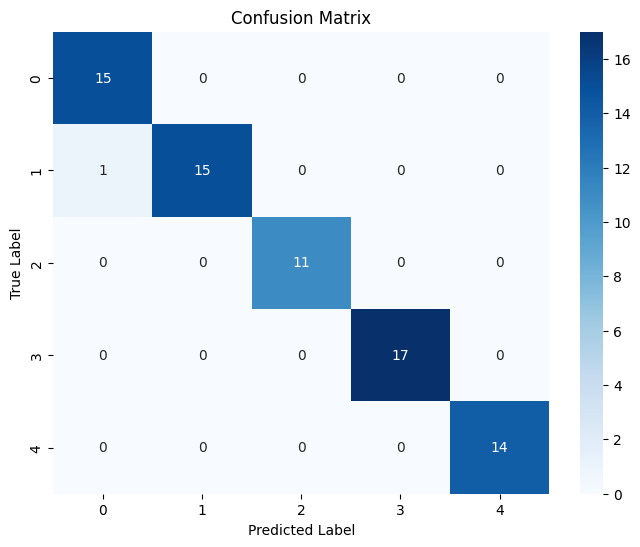


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        14

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73



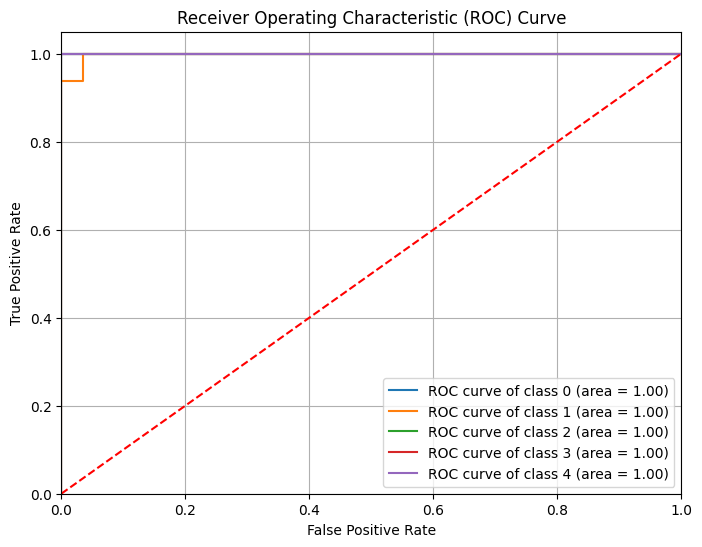

In [16]:
print(f"KNN Model Training")
unbalanced_dataset_knn = KNN(unbalanced_dataset)

2. Naive Bayes

In [17]:
print(f"Naive Bayes Model Training")
unbalanced_dataset_naive_bayes = Naive_Bayes(unbalanced_dataset)

Naive Bayes Model Training
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Hyperparameters: {'model__var_smoothing': 1e-09}
Best Training Accuracy with best model: 0.9217878756969945
Test Accuracy with best model: 0.9452054794520548
Error: No valid model instance created


3. Decision Tree CART

Decision Tree CART Model Training
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Training Accuracy with best model: 1.0
Test Accuracy with best model: 1.0
Confusion Matrix:


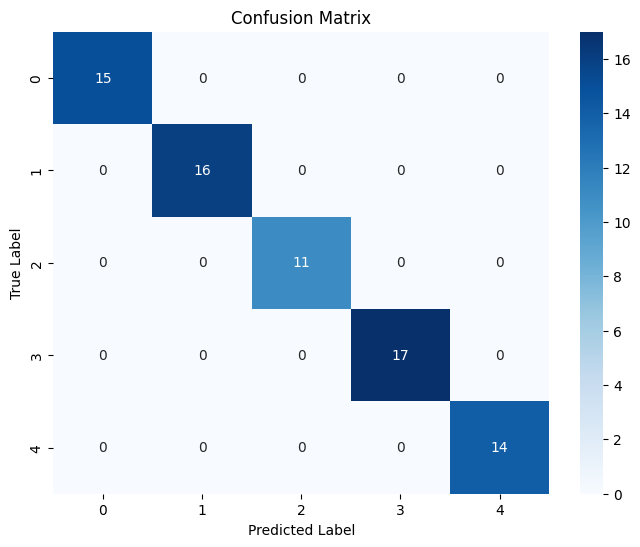


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        14

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



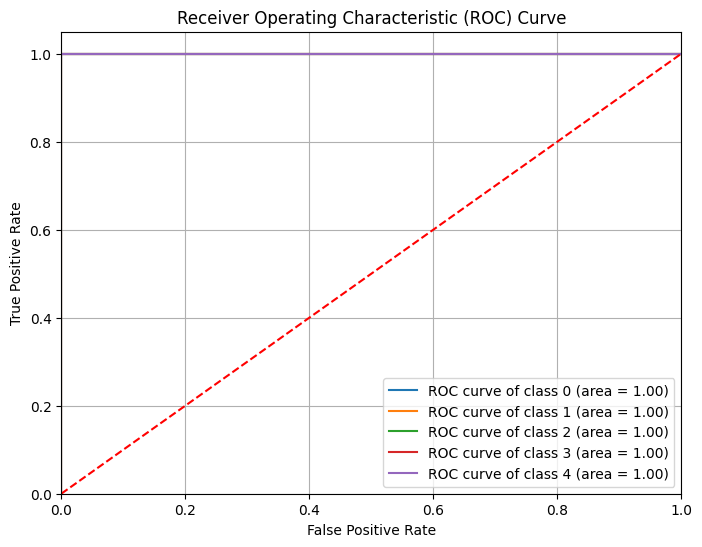

In [18]:
print(f"Decision Tree CART Model Training")
unbalanced_dataset_decision_tree_cart = Decision_Tree_CART(unbalanced_dataset)

4. Decision Tree ID3

Decision Tree ID3 Model Training
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'entropy'}
Best Training Accuracy with best model: 1.0
Test Accuracy with best model: 1.0
Confusion Matrix:


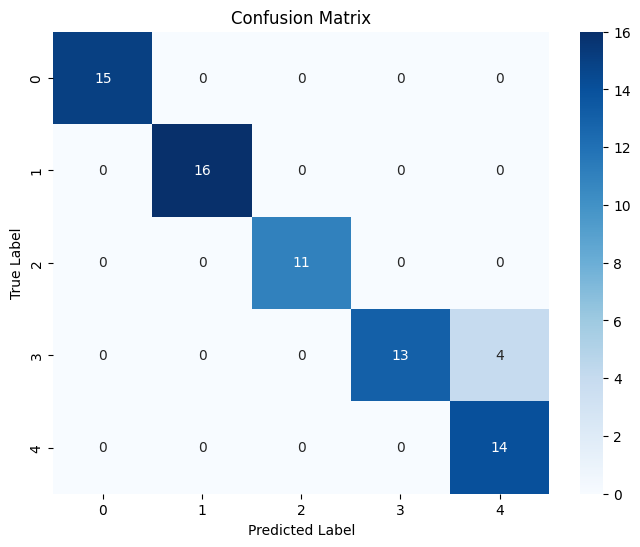


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11
           3       1.00      0.76      0.87        17
           4       0.78      1.00      0.88        14

    accuracy                           0.95        73
   macro avg       0.96      0.95      0.95        73
weighted avg       0.96      0.95      0.94        73



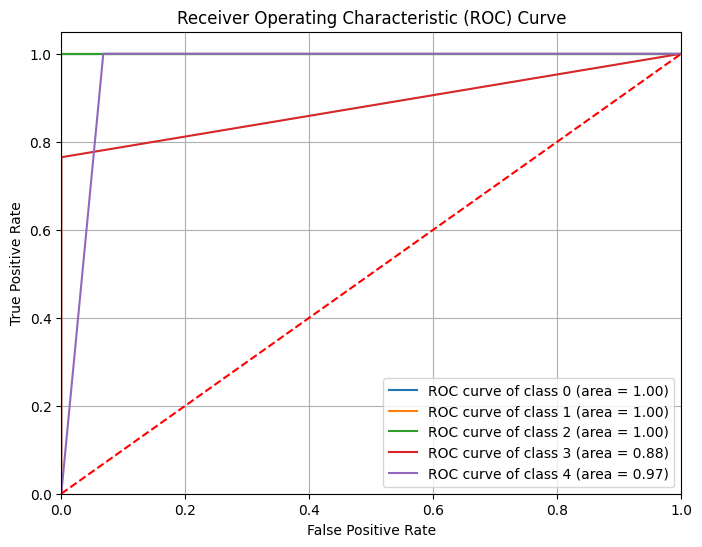

In [19]:
print(f"Decision Tree ID3 Model Training")
unbalanced_dataset_decision_tree_id3 = Decision_Tree_ID3(unbalanced_dataset)

5. SVM

SVM Model Training
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best Hyperparameters: {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Best Training Accuracy with best model: 1.0
Test Accuracy with best model: 1.0
Confusion Matrix:


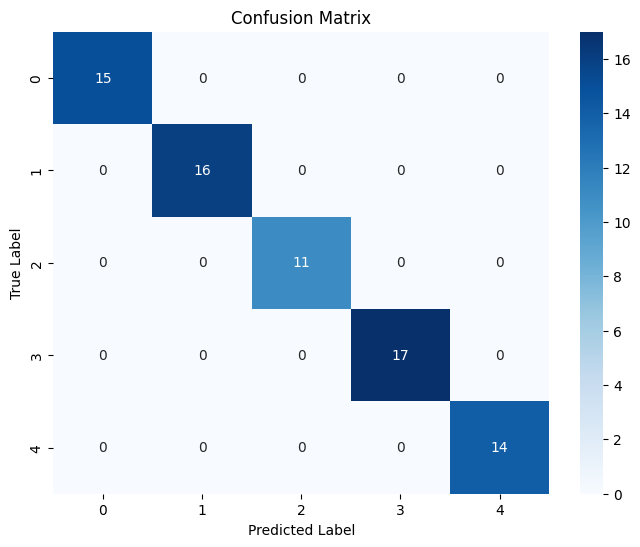


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        14

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



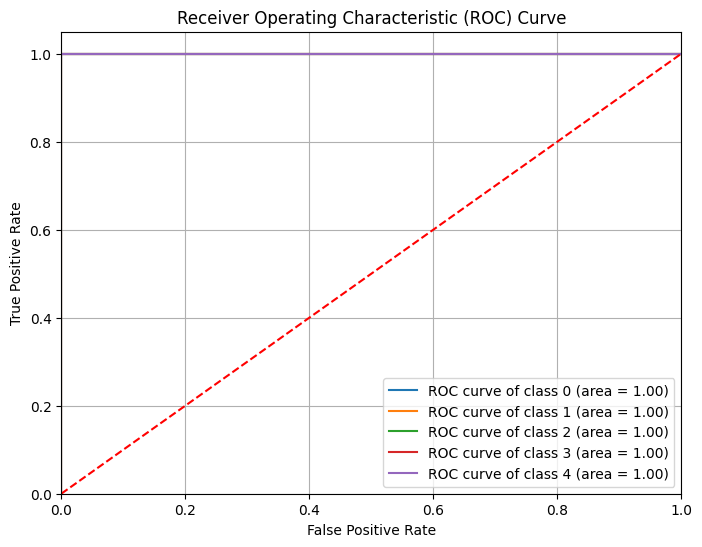

In [21]:
print(f"SVM Model Training")
unbalanced_dataset_svm = SVM(unbalanced_dataset)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training")
unbalanced_dataset_random_forest = Random_Forest(unbalanced_dataset)

Random Forest Model Training
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


# 2. Balaced Dataset

Creating the Dataset

In [ ]:
balancedd_dataset = dataset.copy()
balance_dataset = remove_outliers(balance_dataset , 'Q1Score')

1. KNN

In [ ]:
print(f"KNN Model Training")
balanced_dataset_knn = KNN(balanced_dataset)

2. Naive Bayes

In [ ]:
print(f"Naive Bayes Model Training")
balanced_dataset_naive_bayes = Naive_Bayes(balanced_dataset)

3. Decision Tree CART

In [ ]:
print(f"Decision Tree CART Model Training")
balanced_dataset_decision_tree_cart = Decision_Tree_CART(balanced_dataset)

4. Decision Tree ID3

In [ ]:
print(f"Decision Tree ID3 Model Training")
balanced_dataset_decision_tree_id3 = Decision_Tree_ID3(balanced_dataset)

5. SVM

In [ ]:
print(f"SVM Model Training")
balanced_dataset_svm = SVM(balanced_dataset)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training")
balanced_dataset_random_forest = Random_Forest(balanced_dataset)

# 3. Adding Noise to Numerical Columns

In [ ]:
Q1Score_augmented_dataset = dataset.copy()
noise = np.random.normal(0, 0.1, size=len(dataset))
Q1Score_augmented_dataset['Q1Score_augmented'] = Q1Score_augmented_dataset['Q1Score'] + noise

1. KNN

In [ ]:
print(f"KNN Model Training")
Q1Score_augmented_dataset_knn = KNN(Q1Score_augmented_dataset)

2. Naive Bayes

In [ ]:
print(f"Naive Bayes Model Training")
Q1Score_augmented_dataset_naive_bayes = Naive_Bayes(Q1Score_augmented_dataset)

3. Decision Tree CART

In [ ]:
print(f"Decision Tree CART Model Training")
Q1Score_augmented_dataset_decision_tree_cart = Decision_Tree_CART(Q1Score_augmented_dataset)

4. Decision Tree ID3

In [ ]:
print(f"Decision Tree ID3 Model Training")
Q1Score_augmented_dataset_decision_tree_id3 = Decision_Tree_ID3(Q1Score_augmented_dataset)

5. SVM

In [ ]:
print(f"SVM Model Training")
Q1Score_augmented_dataset_svm = SVM(Q1Score_augmented_dataset)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training")
Q1Score_augmented_dataset_random_forest = Random_Forest(Q1Score_augmented_dataset)

# 4. Creating the Synthetic Combinations

Creating the Dataset

In [ ]:
def generate_synthetic_row(row1, row2):

    synthetic_row = {
        'InterestLoss': (row1['InterestLoss'] + row2['InterestLoss']) / 2,
        'Hopeless': max(row1['Hopeless'], row2['Hopeless']),
        'SleepIssues': min(row1['SleepIssues'], row2['SleepIssues']),
        'LowEnergy': (row1['LowEnergy'] + row2['LowEnergy']) / 2,
        'Appetite': np.random.choice([row1['Appetite'], row2['Appetite']]),
        'UnderPrepared': np.random.choice([row1['UnderPrepared'], row2['UnderPrepared']]),
        'FocusIssues': max(row1['FocusIssues'], row2['FocusIssues']),
        'Restlessness': (row1['Restlessness'] + row2['Restlessness']) / 2,
        'LifeWorth': np.random.choice([row1['LifeWorth'], row2['LifeWorth']]),
        'Q1Score': (row1['Q1Score'] + row2['Q1Score']) / 2,
        'DepSeverity': np.random.choice([row1['DepSeverity'], row2['DepSeverity']])
    }
    return synthetic_row

synthetic_data = pd.DataFrame([
    generate_synthetic_row(dataset.iloc[i], dataset.iloc[j])
    for i in range(len(dataset)) for j in range(len(dataset)) if i != j and np.random.rand() > 0.9
])

augmented_data = pd.concat([dataset, synthetic_data], ignore_index=True)

1. KNN

In [ ]:
print(f"KNN Model Training (Augmented Data)")
augmented_data_knn = KNN(augmented_data)

2. Naive Bayes

In [ ]:
print(f"Naive Bayes Model Training (Augmented Data)")
augmented_data_naive_bayes = Naive_Bayes(augmented_data)

3. Decision Tree CART

In [ ]:
print(f"Decision Tree CART Model Training (Augmented Data)")
augmented_data_decision_tree_cart = Decision_Tree_CART(augmented_data)

4. Decision Tree ID3

In [ ]:
print(f"Decision Tree ID3 Model Training (Augmented Data)")
augmented_data_decision_tree_id3 = Decision_Tree_ID3(augmented_data)

5. SVM

In [ ]:
print(f"SVM Model Training (Augmented Data)")
augmented_data_svm = SVM(augmented_data)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training (Augmented Data)")
augmented_data_random_forest = Random_Forest(augmented_data)

# 5. Feature Shuffling

In [ ]:
def feature_shuffling(data, columns):
    shuffled_data = data.copy()
    for col in columns:
        shuffled_data[col] = np.random.permutation(shuffled_data[col].values)
    return shuffled_data

shuffled_columns = ['InterestLoss', 'Hopeless', 'SleepIssues' , 'LowEnergy' , 'Appetite' , 'UnderPrepared' , 'FocusIssues' , 'Restlessness' , 'LifeWorth']
shuffled_data = feature_shuffling(dataset, shuffled_columns)

1. KNN

In [ ]:
print(f"KNN Model Training")
shuffled_data_knn = KNN(shuffled_data)

2. Naive Bayes

In [ ]:
print(f"Naive Bayes Model Training")
shuffled_data_naive_bayes = Naive_Bayes(shuffled_data)

3. Decision Tree CART

In [ ]:
print(f"Decision Tree CART Model Training")
shuffled_data_decision_tree_cart = Decision_Tree_CART(shuffled_data)

4. Decision Tree ID3

In [ ]:
print(f"Decision Tree ID3 Model Training")
shuffled_data_decision_tree_id3 = Decision_Tree_ID3(shuffled_data)

5. SVM

In [ ]:
print(f"SVM Model Training")
shuffled_data_svm = SVM(shuffled_data)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training")
shuffled_data_random_forest = Random_Forest(shuffled_data)

# 6 . Gaussian Noise

In [ ]:
def add_gaussian_noise(data, column, mean=0, std=0.1):
    noisy_data = data.copy()
    noise = np.random.normal(mean, std, size=len(noisy_data))
    noisy_data[column] += noise
    return noisy_data

noisy_data = add_gaussian_noise(dataset , 'Q1Score', mean=0, std=0.5)

1. KNN

In [ ]:
print(f"KNN Model Training on Noisy Data")
noisy_data_knn = KNN(noisy_data)

2. Naive Bayes

In [ ]:
print(f"Naive Bayes Model Training on Noisy Data")
noisy_data_naive_bayes = Naive_Bayes(noisy_data)

3. Decision Tree CART

In [ ]:
print(f"Decision Tree CART Model Training on Noisy Data")
noisy_data_decision_tree_cart = Decision_Tree_CART(noisy_data)

4. Decision Tree ID3

In [ ]:
print(f"Decision Tree ID3 Model Training on Noisy Data")
noisy_data_decision_tree_id3 = Decision_Tree_ID3(noisy_data)

5. SVM

In [ ]:
print(f"SVM Model Training on Noisy Data")
noisy_data_svm = SVM(noisy_data)

6. Random Forest

In [ ]:
print(f"Random Forest Model Training on Noisy Data")
noisy_data_random_forest = Random_Forest(noisy_data)